# Watershed Model Code

## Model Description 
This is a steady state, layered box model with recharge.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 100 m
- dz = 100 m  

#### Topography
- Land surface 100m above the datum on the left hand side
- sloping linearly to 85m above the datum on the right hand side

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Left boundary constant head 85m
 - Right boundary is a constant head of 70m 
 - Recharge occurs at a rate of 5E-5 m/d uniformly across the domain
 
#### Well: 
 - Pumping well
     - Located at (2500, 2500)
     - Pumping at a rate of 500 m^3/day 

#### Layered Scenario
 - Low K layer - Kx=Ky=Kz=0.0001m/d
 - Extends from 25-35m above the base of the domain
 - The well is only completed in the lowest layer
     

***Return location should be 24 instead of 25*** for segment 2 of the stream

## 1. Setup the environment

In [312]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
from matplotlib import ticker

#jupyter specific--included to show plots in notebook
%matplotlib inline 



## 2. Setup the baseline input variables for all models

In [313]:
# Create the model directory
moddir="C:/Users/conna/Documents/GW_Modeling/GW_Homework/Working/mf2005.exe"

# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay_sub=3  #three layers instead of 1

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

with open('base_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
# print(type(ztop))
#print(ztop.shape)
# print(ztop[0,:])
zbot = 0.     #bottom elevation


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

# Setup Layers in subsurface
botm = np.zeros((nlay_sub,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 45.  

# Set up K Values for domain
K_horiz = 8.5
K_vert = 8.5

# Make a arrays for the K values
Kz = np.zeros((nlay_sub,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:] = 0.0001                   # Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay_sub,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
Kh[1,:,20:] = 0.0001                   # Replace the K in the middle layer with the lower value

# Subsurface properties
n = 0.10        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.10        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

# Boundary and initial conditions - (for bas file)
# Define cell activity (IBOUND)
ibound = np.ones((nlay_sub, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = 0       # Create left side no-flow boundary
ibound[:,0,:] = 0       # Create top no-flow boundary
ibound[:,-1,:] = 0      # Create bottom no-flow boundary
ibound[:,:,-1] = -1      # Create right constant head boundary

# Create bedrock bounds and no flow boundaries 
for i in range(0,9):
    if i <= 5:                              # Loop to create the top layer of bedrock 
            ibound[0, i, 0:5-i] = 0
            ibound[0, -1-i, 0:5-i] = 0
    elif 6 <= i <= 7:                       # Loop to create the middle layer of bedrock
        for j in range(0,7):
            ibound[1,j,0:7-j] = 0
            ibound[1,-1-j,0:7-j] = 0
    else:
        for k in range(0,9):                # Loop to create the bottom layer of bedrock
            ibound[2,k,0:9-k] = 0
            ibound[2, -1-k, 0:9-k] = 0

# Boundary Head conditions
h_right = 70

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay_sub, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value

## Recharge
recharge = 4e-5 #m/day
rech_zone = np.zeros((1,nrow,ncol))  #define an array of zeros of dim (nrow,ncol)
rech_zone[:,:,0:15] = recharge

# ET
ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[:,25:] = 1e-5
ET_zone[22:28,:] = 5e-4       # ET in Riparian area
# ET_zone[22:28,:] = 5e-5       # ET in Riparian area (most recent version of github)
extinction_depth = 1
#extinction depth is the depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation


## 3. Create No Town, No Ag Model (NTNA)

#### Setup the stream package

In [314]:
modelname1 = "NTNA_model"
m1 = flopy.modflow.Modflow(modelname1, exe_name = moddir)

# Replace with RIV package

# # Which layer is the strea plotting in?

# # User inputs:
# nseg = 3
# ntrib = 2
# slope = 0.001                        #slope of streambed (m/m)
# rough = 0.04                         #roughness of streambed
# width = 1.                           #x-sectional width of channel (m)
# Flow_into_the_1st_reach = 0    # m^3/day
# Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# # str settings
# set_icalc = 1                   #1 if the stage is to be calculated based on flow, otherwise specify below
# const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
# istcb2 = 53                          #save outflows to cbb file

# # Calculate conductivity
# k_strbott = (1.36*K_horiz)                      #river bottom hydraulic conductivity in f/d
# sed_thick = 1                      #thickness of riverbed sediment in f

# str_cond = (k_strbott*(dy)*(width))/(sed_thick) #river bed conductance in f^2/d

# # Setup reach locations
# nreach = 50
# str_rows = 24*np.ones((nreach),dtype=np.int32)
# str_cols = np.arange(0,nreach)

# # Setup reach inflows
# Qreturn = 0        # Return flow from town (Set to zero when town not present in model)
# return_loc = 24     # Cell location of return flow from town to stream
# reach_flow = np.zeros((nreach),dtype=np.int32)      # initially sets all inflows to zero for all reaches
# reach_flow[return_loc] = Qreturn      # inflow to segment 2 --> return from town
# reach_flow[return_loc+1] = -1         # inflow to segment 3 --> sum of all previous segments

# # Setup segment numbers
# segments = np.ones((nreach),dtype=np.int32)
# segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
# segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

# # Setup reach numbers (Numbers reaches within each segment) 
# reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50 (numbering moves downstream)
# reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
# reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

# # Setup the elevation of the stream segments
# ztop = np.genfromtxt('base_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
# surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream
# # loop over the stream reaches and pull the land surface elevation for the location of each stream cell
# for i in np.arange(nreach): 
#       surf_elev[i] = ztop[str_rows[i],str_cols[i]]
# str_top = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
# str_bot = str_top - sed_thick      # elevation of the bottom of the streambed (m)
# stage_elev = str_top + Stage_above_datum      # elevation of the water surface in the stream (m)

# # Setup the stress period dictionary
# str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values
# # Loop over the reaches and setup the data
# for r in np.arange(nreach): 
#      str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], 
#                       str_cond, str_bot[r], str_top[r], width, slope, rough]
# str_spd = {0: str_info} # save the stream info in a stress period dictionary

# # Setup the segments dictionary
# #for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
# seg_info = np.zeros((10,nseg))
# seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
# str_segd = {0: seg_info}  #save the stream info in a segment dictionary

# strm = flopy.modflow.mfstr.ModflowStr(m1, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


#### Setup basic MODFLOW packages and run NTNA model

In [315]:
# Put all of the basic packages in here

# Discretization - dis
dis = flopy.modflow.ModflowDis(model=m1, nlay=nlay_sub, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# bas package
bas = flopy.modflow.ModflowBas(m1, ibound=ibound, strt=H_init)

# Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m1, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

# Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m1, rech=rech_zone, ipakcb=53)

# ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(model=m1, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)

# # Well - wel
# wel = flopy.modflow.ModflowWel(model=m1, stress_period_data=wel_spd)

# Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m1, stress_period_data=spd, compact=True)

# Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m1)

# write the inputs
m1.write_input()

# Run the model 
success, mfoutput = m1.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


FloPy is using the following executable to run the model: C:/Users/conna/Documents/GW_Modeling/GW_Homework/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: NTNA_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 20:44:47

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 20:44:47
 Elapsed run time:  0.149 Seconds

  Normal termination of simulation


### Plot NTNA model grid and boundary conditions

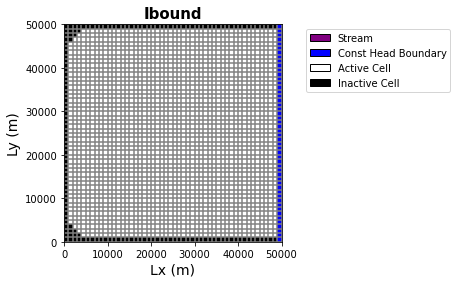

In [316]:
modelmap = flopy.plot.PlotMapView(model=m1, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
# str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

### Plot NTNA cross section of subsurface layers

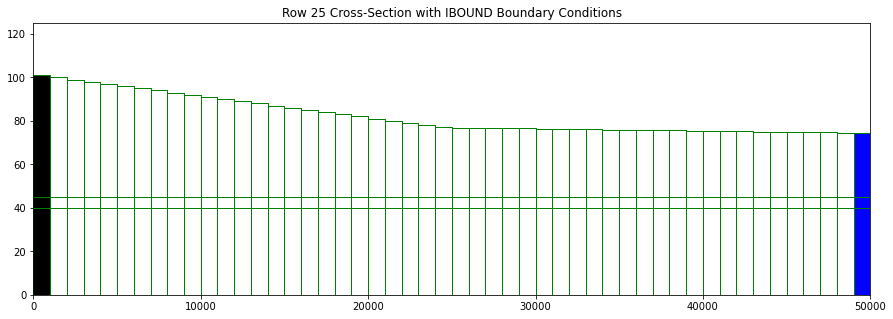

In [317]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='black', color_ch='blue')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

### Plot subsurface head cross section

In [ ]:

# fig = plt.figure(figsize=(15, 5))
# ax0 = fig.add_subplot(2, 1, 1)

# # Top Layer Well - Ag Well
# xsect0 = flopy.plot.PlotCrossSection(model=m3, line={'row': 12}) #note use the key 'column' if you want to plot a column instaed
# pc = xsect0.plot_array(head3_0, masked_values=[999.], head=head3_0, alpha=0.5)
# patches = xsect0.plot_ibound(head=head3_0)
# # ax0.set_aspect('equal')
# ax0.set_ylabel('Depth (z) [m]', fontsize=10)
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect0.plot_grid(color='black', lw=0.5)
# t = ax0.set_title('3 Layer Model Row 25 Cross-Section')
# fig.colorbar(pc, ax=ax0, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect0.plot_surface(head3_0[0,:,:], masked_values=[999.], color='blue', lw=1)

# ax1 = fig.add_subplot(3, 1, 2)
# # 3 Layer Model Run 2
# xsect1 = flopy.plot.PlotCrossSection(model=m3_one, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
# pc1 = xsect1.plot_array(head3_1, masked_values=[999.], head=head3_0, alpha=0.5)
# patches = xsect1.plot_ibound(head=head3_1)
# ax1.set_ylabel('Depth (z) [m]', fontsize=10)
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect1.plot_grid(color='black', lw=0.5)
# fig.colorbar(pc1, ax=ax1, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect1.plot_surface(head3_0[0,:,:], masked_values=[999.], color='blue', lw=1)

## 4. Create Yes Town, No Ag Model (YTNA)

### Adjust the input variables to include Well

In [318]:
modelname2 = "YTNA_model"
m2 = flopy.modflow.Modflow(modelname2, exe_name = moddir)

# Use well code from Farm code for multiple wells
# sp_fluxes = {0: [wildfluxes, acme1fluxes, acme2fluxes]}   #create a dictionary with entries for each stress period


# Well setup
pumping = -1500 #m3/day  #given
well_row = 21
well_col= 38
well_loc = (2,well_row,well_col) #Well loc should be layer, row, column
# print(well_loc)
well_1 = [i for i in well_loc] + [pumping]
wel_spd = {0: [well_1]} #putting the well in the bottom layer
#print(well_col)
print(well_1)

[2, 21, 38, -1500]


#### Setup the stream package

In [319]:
# Replace with RIV package

# # User inputs:
# nseg = 3
# ntrib = 2
# slope = 0.001                        #slope of streambed (m/m)
# rough = 0.04                         #roughness of streambed
# width = 1.                           #x-sectional width of channel (m)
# Flow_into_the_1st_reach = 0    # m^3/day
# Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# # str settings
# set_icalc = 1                   #1 if the stage is to be calculated based on flow, otherwise specify below
# const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
# istcb2 = 53                          #save outflows to cbb file

# # Calculate conductivity
# k_strbott = (1.36*K_horiz)                      #river bottom hydraulic conductivity in f/d
# sed_thick = 1                      #thickness of riverbed sediment in f

# str_cond = (k_strbott*(dy)*(width))/(sed_thick) #river bed conductance in f^2/d

# # Setup reach locations
# nreach = 50
# str_rows = 24*np.ones((nreach),dtype=np.int32)
# str_cols = np.arange(0,nreach)

# # Setup reach inflows
# Qreturn = 0        # Return flow from town (Set to zero when town not present in model)
# return_loc = 24     # Cell location of return flow from town to stream
# reach_flow = np.zeros((nreach),dtype=np.int32)      # initially sets all inflows to zero for all reaches
# reach_flow[return_loc] = Qreturn      # inflow to segment 2 --> return from town
# reach_flow[return_loc+1] = -1         # inflow to segment 3 --> sum of all previous segments

# # Setup segment numbers
# segments = np.ones((nreach),dtype=np.int32)
# segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
# segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

# # Setup reach numbers (Numbers reaches within each segment) 
# reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50 (numbering moves downstream)
# reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
# reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

# # Setup the elevation of the stream segments
# ztop = np.genfromtxt('base_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
# surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream
# # loop over the stream reaches and pull the land surface elevation for the location of each stream cell
# for i in np.arange(nreach): 
#       surf_elev[i] = ztop[str_rows[i],str_cols[i]]
# str_top = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
# str_bot = str_top - sed_thick      # elevation of the bottom of the streambed (m)
# stage_elev = str_top + Stage_above_datum      # elevation of the water surface in the stream (m)

# # Setup the stress period dictionary
# str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values
# # Loop over the reaches and setup the data
# for r in np.arange(nreach): 
#      str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], 
#                       str_cond, str_bot[r], str_top[r], width, slope, rough]
# str_spd = {0: str_info} # save the stream info in a stress period dictionary

# # Setup the segments dictionary
# #for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
# seg_info = np.zeros((10,nseg))
# seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
# str_segd = {0: seg_info}  #save the stream info in a segment dictionary

# strm = flopy.modflow.mfstr.ModflowStr(m2, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


#### Setup basic MODFLOW packages and run YTNA model

In [320]:
# Put all of the basic packages in here

# Discretization - dis
dis = flopy.modflow.ModflowDis(model=m2, nlay=nlay_sub, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# bas package
bas = flopy.modflow.ModflowBas(m2, ibound=ibound, strt=H_init)

# Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m2, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

# Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m2, rech=rech_zone, ipakcb=53)

# ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(model=m2, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)

# Well - wel
wel = flopy.modflow.ModflowWel(model=m2, stress_period_data=wel_spd)

# Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m2, stress_period_data=spd, compact=True)

# Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m2)

# write the inputs
m2.write_input()

# Run the model 
success, mfoutput = m2.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


FloPy is using the following executable to run the model: C:/Users/conna/Documents/GW_Modeling/GW_Homework/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: YTNA_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 20:44:48

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 20:44:48
 Elapsed run time:  0.086 Seconds

  Normal termination of simulation


### Plot YTNA model grid and boundary conditions

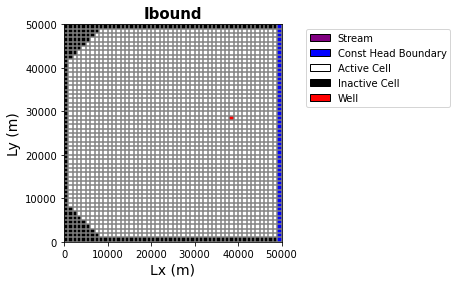

In [333]:
modelmap = flopy.plot.PlotMapView(model=m2, layer=2)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
wel_m = modelmap.plot_bc("WEL")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='red', label='Well',ec='black')],
                                      bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

### Plot YTNA cross section of subsurface layers

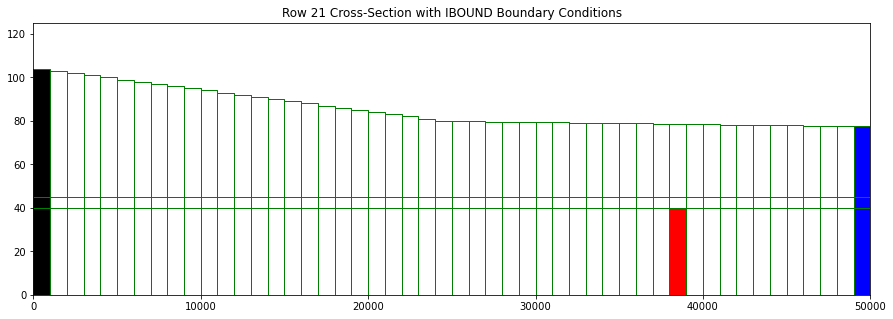

In [322]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m2, line={'row': 21}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='black', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 21 Cross-Section with IBOUND Boundary Conditions')

### Plot subsurface head cross section

In [ ]:

# fig = plt.figure(figsize=(15, 5))
# ax0 = fig.add_subplot(2, 1, 1)

# # Top Layer Well - Ag Well
# xsect0 = flopy.plot.PlotCrossSection(model=m3, line={'row': 12}) #note use the key 'column' if you want to plot a column instaed
# pc = xsect0.plot_array(head3_0, masked_values=[999.], head=head3_0, alpha=0.5)
# patches = xsect0.plot_ibound(head=head3_0)
# # ax0.set_aspect('equal')
# ax0.set_ylabel('Depth (z) [m]', fontsize=10)
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect0.plot_grid(color='black', lw=0.5)
# t = ax0.set_title('3 Layer Model Row 25 Cross-Section')
# fig.colorbar(pc, ax=ax0, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect0.plot_surface(head3_0[0,:,:], masked_values=[999.], color='blue', lw=1)

# ax1 = fig.add_subplot(3, 1, 2)
# # 3 Layer Model Run 2
# xsect1 = flopy.plot.PlotCrossSection(model=m3_one, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
# pc1 = xsect1.plot_array(head3_1, masked_values=[999.], head=head3_0, alpha=0.5)
# patches = xsect1.plot_ibound(head=head3_1)
# ax1.set_ylabel('Depth (z) [m]', fontsize=10)
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect1.plot_grid(color='black', lw=0.5)
# fig.colorbar(pc1, ax=ax1, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect1.plot_surface(head3_0[0,:,:], masked_values=[999.], color='blue', lw=1)

## 5. Create Yes Town, Yes Ag Model (YTYA)

### Adjust the input variables to include Well and Ag

In [323]:
modelname3 = "YTYA_model"
m3 = flopy.modflow.Modflow(modelname3, exe_name = moddir)

# Well setup
pumping = -1500 #m3/day  #given
well_row = 21
well_col= 38
well_loc = (2,well_row,well_col) #Well loc should be layer, row, column
# print(well_loc)
well_1 = [i for i in well_loc] + [pumping]
#print(well_col)
print(well_1)

# AG FIELD
# Recharge
crop_dem = 0.006
field_rech = (crop_dem*0.2*0.125)        # Assuming field growing pistachios, crop demand of 0.006 m/day --> 0.006*0.125*0.2
rech_zone[21:23,19:21] = field_rech

# Well
pumping = -4500 #m3/day  #given
well_row = 12
well_col= 14
well_loc = (0,well_row,well_col) #Well loc should be layer, row, column
well_2 = [i for i in well_loc] + [pumping]
wel_spd = {0: [well_1, well_2]} #putting the well in the bottom layer
# print(well_loc)
print(well_2)

[2, 21, 38, -1500]
[0, 12, 14, -4500]


#### Setup the stream package

In [324]:
# Replace with RIV package

# # Which layer is the strea plotting in?

# # User inputs:
# nseg = 3
# ntrib = 2
# slope = 0.001                        #slope of streambed (m/m)
# rough = 0.04                         #roughness of streambed
# width = 1.                           #x-sectional width of channel (m)
# Flow_into_the_1st_reach = 0    # m^3/day
# Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# # str settings
# set_icalc = 1                   #1 if the stage is to be calculated based on flow, otherwise specify below
# const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
# istcb2 = 53                          #save outflows to cbb file

# # Calculate conductivity
# k_strbott = (1.36*K_horiz)                      #river bottom hydraulic conductivity in f/d
# sed_thick = 1                      #thickness of riverbed sediment in f

# str_cond = (k_strbott*(dy)*(width))/(sed_thick) #river bed conductance in f^2/d

# # Setup reach locations
# nreach = 50
# str_rows = 24*np.ones((nreach),dtype=np.int32)
# str_cols = np.arange(0,nreach)

# # Setup reach inflows
# Qreturn = 0        # Return flow from town (Set to zero when town not present in model)
# return_loc = 24     # Cell location of return flow from town to stream
# reach_flow = np.zeros((nreach),dtype=np.int32)      # initially sets all inflows to zero for all reaches
# reach_flow[return_loc] = Qreturn      # inflow to segment 2 --> return from town
# reach_flow[return_loc+1] = -1         # inflow to segment 3 --> sum of all previous segments

# # Setup segment numbers
# segments = np.ones((nreach),dtype=np.int32)
# segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
# segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

# # Setup reach numbers (Numbers reaches within each segment) 
# reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50 (numbering moves downstream)
# reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
# reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

# # Setup the elevation of the stream segments
# ztop = np.genfromtxt('base_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
# surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream
# # loop over the stream reaches and pull the land surface elevation for the location of each stream cell
# for i in np.arange(nreach): 
#       surf_elev[i] = ztop[str_rows[i],str_cols[i]]
# str_top = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
# str_bot = str_top - sed_thick      # elevation of the bottom of the streambed (m)
# stage_elev = str_top + Stage_above_datum      # elevation of the water surface in the stream (m)

# # Setup the stress period dictionary
# str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values
# # Loop over the reaches and setup the data
# for r in np.arange(nreach): 
#      str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], 
#                       str_cond, str_bot[r], str_top[r], width, slope, rough]
# str_spd = {0: str_info} # save the stream info in a stress period dictionary

# # Setup the segments dictionary
# #for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
# seg_info = np.zeros((10,nseg))
# seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
# str_segd = {0: seg_info}  #save the stream info in a segment dictionary

# strm = flopy.modflow.mfstr.ModflowStr(m3, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


#### Setup basic MODFLOW packages and run YTYA model

In [325]:
# Put all of the basic packages in here

# Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay_sub, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# bas package
bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

# Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

# Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=rech_zone, ipakcb=53)

# ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(model=m3, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)

# Well - wel
wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=wel_spd)

# Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

# Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3)

# write the inputs
m3.write_input()

# Run the model 
success, mfoutput = m3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


FloPy is using the following executable to run the model: C:/Users/conna/Documents/GW_Modeling/GW_Homework/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: YTYA_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 20:44:49

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 20:44:50
 Elapsed run time:  0.090 Seconds

  Normal termination of simulation


### Plot YTYA model grid and boundary conditions

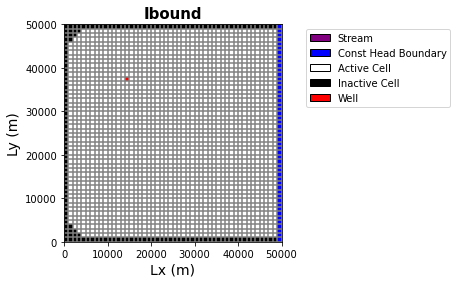

In [331]:
modelmap = flopy.plot.PlotMapView(model=m3, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
wel_m = modelmap.plot_bc("WEL")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='red', label='Well',ec='black')],
                                      bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

### Plot YTYA cross section of subsurface layers

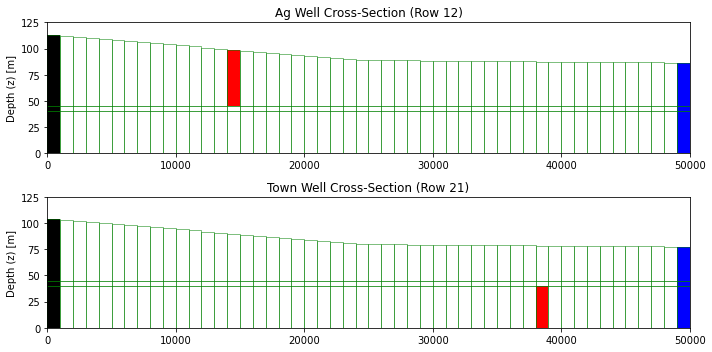

In [350]:
# fig = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(1, 1, 1)

# xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 12}) #note use the key 'column' if you want to plot a column instead
# patches = xsect.plot_ibound(color_noflow='black', color_ch='blue')
# patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')



fig = plt.figure(figsize=(10, 5))
ax0 = fig.add_subplot(2, 1, 1)

# Top Layer Well - Ag Well
xsect0 = flopy.plot.PlotCrossSection(model=m3, line={'row': 12}) #note use the key 'column' if you want to plot a column instaed
patches = xsect0.plot_ibound(color_noflow='black', color_ch='blue')
patches = xsect0.plot_bc('WEL', color='red', label='Ag Well')
linecollection = xsect0.plot_grid(color='green', lw=0.5)
# ax0.set_aspect('equal')
ax0.set_ylabel('Depth (z) [m]', fontsize=10)
t = ax0.set_title('Ag Well Cross-Section (Row 12)')
# plt.legend()

ax1 = fig.add_subplot(2, 1, 2)
# 3 Layer Model Run 2
xsect1 = flopy.plot.PlotCrossSection(model=m3, line={'row': 21}) #note use the key 'column' if you want to plot a column instaed
patches1 = xsect1.plot_ibound(color_noflow='Black', color_ch='blue')
patches1 = xsect1.plot_bc('WEL', color='red', label= 'Town Well')
linecollection = xsect1.plot_grid(color='green', lw=0.5)
ax1.set_ylabel('Depth (z) [m]', fontsize=10)
t1 = ax1.set_title('Town Well Cross-Section (Row 21)')
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# plt.legend()
fig.tight_layout()

#### Read in outputs

In [ ]:
# Head
headobj3 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
times3 = headobj3.get_times()                 #returns a list of timesteps
head3 = headobj3.get_data(totim=times3[-1])   #returns a numpy array of heads for specified time (last timestep)


#Water balance
budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
print(budgobj3.get_unique_record_names())
kstpkper_list = budgobj3.get_kstpkper()          #returns a list of stress periods & timesteps
frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 

# #Water balance - 3 layer, adjusted to 1 layer
# budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
# print(budgobj3.get_unique_record_names())
# kstpkper_list3 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
# frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
# fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
# recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
# print(len(frf3))



# #Water balance - 3 layer, Run 1
# budgobj3_0 = bf.CellBudgetFile(modelname3_0+'.cbc')   #reads the cell budget file    
# print(budgobj3_0.get_unique_record_names())
# kstpkper_list3_0 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
# frf3_0 = budgobj3_0.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
# fff3_0 = budgobj3_0.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
# recharge3_0 = budgobj3_0.get_data(text='RECHARGE', totim=1.0) 
# print(len(frf3_0))

# #Water balance - 3 layer, Run 2
# budgobj3_1 = bf.CellBudgetFile(modelname3_1+'.cbc')   #reads the cell budget file    
# print(budgobj3_1.get_unique_record_names())
# kstpkper_list3_1 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
# frf3_1 = budgobj3_1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
# fff3_1 = budgobj3_1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
# recharge3 = budgobj3_1.get_data(text='RECHARGE', totim=1.0) 
# print(len(frf3_1))

# #Water balance - 3 layer, Run 3
# budgobj3_2 = bf.CellBudgetFile(modelname3_2+'.cbc')   #reads the cell budget file    
# print(budgobj3_2.get_unique_record_names())
# kstpkper_list3_2 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
# frf3_2 = budgobj3_2.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
# fff3_2 = budgobj3_2.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
# recharge3 = budgobj3_2.get_data(text='RECHARGE', totim=1.0) 
# print(len(frf3_2))


[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE']


### Plot ET, Recharge, and WTD

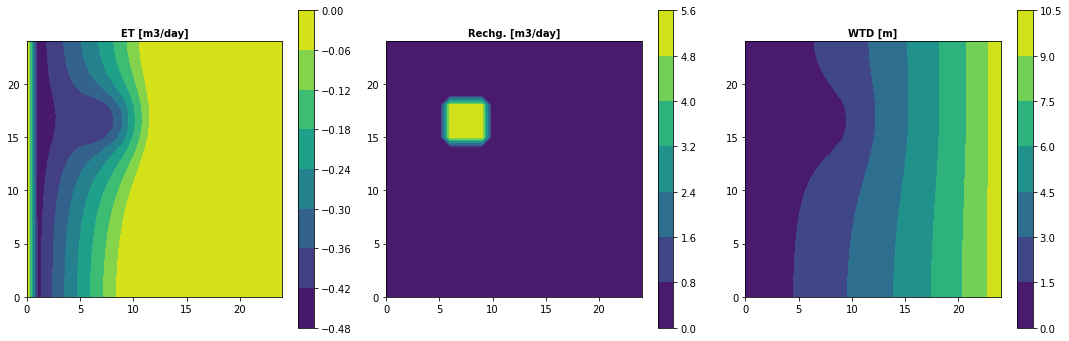

In [ ]:
#Plot ET, Recharge and WTD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
fig.tight_layout(pad=3.0)

#ET
#ax1.set_xlabel('Lx (m)', fontsize=10)
#ax1.set_ylabel('Ly (m)', fontsize=10)
ax1.set_title('ET [m3/day]', fontsize=10, fontweight='bold')
ax1.set_aspect('equal')
etplot = ax1.contourf(np.flipud(et_vals))
fig.colorbar(etplot, ax=ax1, shrink=0.3)

#Recharge
#ax2.set_xlabel('Lx (m)', fontsize=10)
#ax2.set_ylabel('Ly (m)', fontsize=10)
ax2.set_title('Rechg. [m3/day]', fontsize=10, fontweight='bold')
ax2.set_aspect('equal')
rchplot = ax2.contourf(np.flipud(recharge_vals))
fig.colorbar(rchplot, ax=ax2, shrink=0.3)


#WTD
#Calcualte WTD at the domain thickness (ztop) minus the head
WTD = ztop-head
#ax3.set_xlabel('Lx (m)', fontsize=10)
#ax3.set_ylabel('Ly (m)', fontsize=10)
ax3.set_title('WTD [m]', fontsize=10, fontweight='bold')
ax3.set_aspect('equal')
wtdplot = ax3.contourf(np.flipud(WTD[0,:,:]))
fig.colorbar(wtdplot, ax=ax3, shrink=0.3)

fig.tight_layout()
plt.show()


### Plot subsurface head cross section

In [ ]:

fig = plt.figure(figsize=(15, 5))
ax0 = fig.add_subplot(3, 1, 1)

# Top Layer Well - Ag Well
xsect0 = flopy.plot.PlotCrossSection(model=m3, line={'row': 12}) #note use the key 'column' if you want to plot a column instaed
pc = xsect0.plot_array(head3_0, masked_values=[999.], head=head3_0, alpha=0.5)
patches = xsect0.plot_ibound(head=head3_0)
# ax0.set_aspect('equal')
ax0.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect0.plot_grid(color='black', lw=0.5)
t = ax0.set_title('3 Layer Model Row 25 Cross-Section')
fig.colorbar(pc, ax=ax0, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect0.plot_surface(head3_0[0,:,:], masked_values=[999.], color='blue', lw=1)

ax1 = fig.add_subplot(3, 1, 2)
# 3 Layer Model Run 2
xsect1 = flopy.plot.PlotCrossSection(model=m3_one, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc1 = xsect1.plot_array(head3_1, masked_values=[999.], head=head3_0, alpha=0.5)
patches = xsect1.plot_ibound(head=head3_1)
ax1.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect1.plot_grid(color='black', lw=0.5)
fig.colorbar(pc1, ax=ax1, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect1.plot_surface(head3_0[0,:,:], masked_values=[999.], color='blue', lw=1)


ax2 = fig.add_subplot(3, 1, 2)
# 3 Layer Model Run 2
xsect2 = flopy.plot.PlotCrossSection(model=m3_one, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc2 = xsect2.plot_array(head3_1, masked_values=[999.], head=head3_0, alpha=0.5)
patches = xsect2.plot_ibound(head=head3_1)
ax2.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect2.plot_grid(color='black', lw=0.5)
fig.colorbar(pc2, ax=ax2, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect2.plot_surface(head3_0[0,:,:], masked_values=[-999.99], color='blue', lw=1)

# 7. Read in the outputs

### 7.1 Modflow outputs - Heads and budget files

# 8. Plotting


### 8.2 Three Layer Cross Section Plots

NameError: name 'head3' is not defined

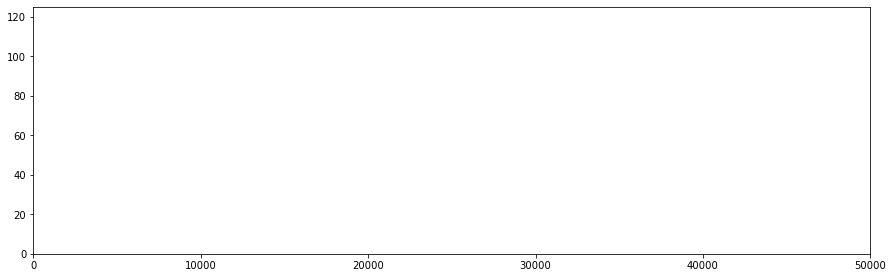

In [329]:
# Masked value needs to be -999.99 to get head values in order to have plots show up right
# add this to water table depth chart
# Head2 = head.copy()
# head2[head2 == -999.99] = np.NAN
# WTD = ztop-head2
# can do all this when headobj read into code



# Plot 1 and 3 layer Model Cross sections
fig = plt.figure(figsize=(15, 10))
ax0 = fig.add_subplot(2, 1, 1)

# 1 Layer Model Run
xsect0 = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect0.plot_array(head1, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect0.plot_ibound(head=head1)
# ax0.set_aspect('equal')
ax0.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect0.plot_grid(color='black', lw=0.5)
t = ax0.set_title('1 Layer Model Row 25 Cross-Section')
fig.colorbar(pc, ax=ax0, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect0.plot_surface(head1[0,:,:], masked_values=[999.], color='blue', lw=1)

ax1 = fig.add_subplot(2, 1, 2)
# 3 Layer Model Run 2
xsect1 = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc1 = xsect1.plot_array(head3, masked_values=[-999.99], head=head3, alpha=0.5)
patches = xsect1.plot_ibound(head=head3)
ax1.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect1.plot_grid(color='black', lw=0.5)
t = ax1.set_title('3 Layer Model Row 25 Cross-Section')
fig.colorbar(pc1, ax=ax1, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect1.plot_surface(head3[0,:,:], masked_values=[-999.99], color='blue', lw=1)


fig.tight_layout()

### 8.3 Three Layer Cross Section Plots

In [ ]:
# # Plot 3 layer Model Cross sections
# fig = plt.figure(figsize=(15, 10))
# ax0 = fig.add_subplot(3, 1, 1)

# # 3 Layer Model Run 1
# xsect0 = flopy.plot.PlotCrossSection(model=m3_zero, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
# pc = xsect0.plot_array(head3_0, masked_values=[999.], head=head3_0, alpha=0.5)
# patches = xsect0.plot_ibound(head=head3_0)
# # ax0.set_aspect('equal')
# ax0.set_ylabel('Depth (z) [m]', fontsize=10)
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect0.plot_grid(color='black', lw=0.5)
# t = ax0.set_title('3 Layer Model Row 25 Cross-Section')
# fig.colorbar(pc, ax=ax0, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect0.plot_surface(head3_0[0,:,:], masked_values=[999.], color='blue', lw=1)

# ax1 = fig.add_subplot(3, 1, 2)
# # 3 Layer Model Run 2
# xsect1 = flopy.plot.PlotCrossSection(model=m3_one, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
# pc1 = xsect1.plot_array(head3_1, masked_values=[999.], head=head3_0, alpha=0.5)
# patches = xsect1.plot_ibound(head=head3_1)
# ax1.set_ylabel('Depth (z) [m]', fontsize=10)
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect1.plot_grid(color='black', lw=0.5)
# fig.colorbar(pc1, ax=ax1, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect1.plot_surface(head3_0[0,:,:], masked_values=[999.], color='blue', lw=1)

# ax2 = fig.add_subplot(3, 1, 3)
# # 3 Layer Model Run 3
# xsect2 = flopy.plot.PlotCrossSection(model=m3_two, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
# pc2 = xsect2.plot_array(head3_2, masked_values=[999.], head=head3_0, alpha=0.5)
# patches = xsect2.plot_ibound(head=head3_2)
# ax2.set_xlabel('Distance (x) [m]', fontsize=10)
# ax2.set_ylabel('Depth (z) [m]', fontsize=10)
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect2.plot_grid(color='black', lw=0.5)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect2.plot_surface(head3_0[0,:,:], masked_values=[999.], color='blue', lw=1)
# fig.colorbar(pc2, ax=ax2, shrink=0.75)

# fig.tight_layout()

# 9. Additional plots
### 9.1 Plot head transect

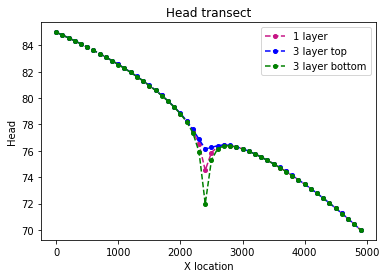

In [ ]:
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0,5000,100) 
plt.plot(x,head1[0,int(well_row),:],marker='o', color='mediumvioletred', markersize=4, linestyle='--', label="1 layer")
plt.plot(x,head3[0,int(well_row),:],marker='o', color='blue', markersize=4, linestyle='--', label="3 layer top")
# plt.plot(x,head3_2[1,int(well_row),:],marker='o', color='r', markersize=4, linestyle='--', label="3 layer middle")
plt.plot(x,head3[2,int(well_row),:],marker='o', color='green', markersize=4, linestyle='--', label="3 layer bottom")
plt.title('Head transect')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()

# plt.savefig('Head_Transect.png')

### 9.3 3 Layer head contours

C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\conna\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


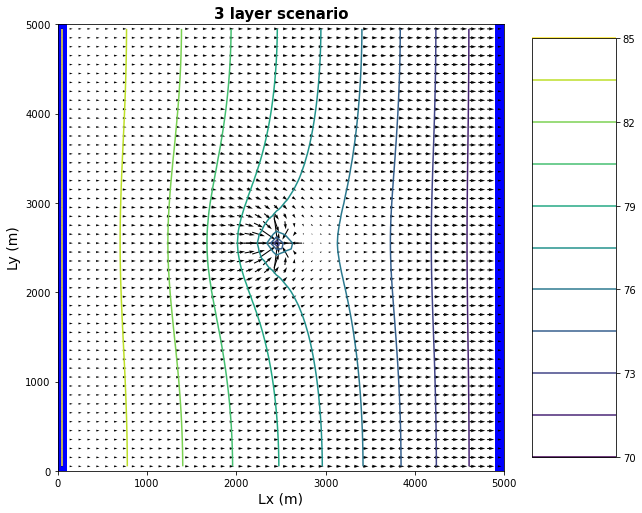

In [ ]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m3, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf3[0], fff3[0], head=head3) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('3 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   